In [1]:
"""
Random walk model
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import Constant_M
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 



/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization
Random walk has unit root and therefore is not stationary. A random walk may be written as:

$y_t = y_{t-1} + \varepsilon_{t-1}$

In `my_f`, I specify an AR(1) type model without resticting $\phi<1$.

In [2]:
def my_f(theta):
    """
    Random Walk
    """
    # Generate F
    phi = theta[0]  # I did not make restriction on phi
    sig = np.exp(theta[1])
    F = np.array([[phi]])
    # Generate Q
    Q = np.array([[sig]]) 
    R = np.zeros([1, 1])
    # Generate H
    H = np.array([[1]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R}

    return M


In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, is_warning=False)
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000}, verbose=True) 

# Generate Synthetic Data

In [5]:
# Some initial parameters
theta = np.array([1, -0.1])  
T = 1000
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  
missing_range = [0.3, 0.5]

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Insert some missingness
missing_start_t = np.floor(T * missing_range[0]).astype(int)
missing_end_t = np.floor(T * missing_range[1]).astype(int)
is_missing = (df.index >= missing_start_t) & (df.index < missing_end_t)
df.loc[is_missing, ['y_0']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ks_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ks_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ks_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ks_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

ERROR:root:No traceback has been produced, nothing to debug.


theta is [1.00734413 0.35788302]. Function value is: -496.2066549145931.
theta is [1.00734413 0.35788302]. Function value is: -496.2066549145931.
theta is [1.00734413 0.35788302]. Function value is: -496.2066549145931.
theta is [1.00734413 0.35788302]. Function value is: -496.2066549145931.
theta is [1.00734413 0.35788302]. Function value is: -496.2066549145931.
theta is [1.00441581 0.34297123]. Function value is: -490.5835840838461.
theta is [1.00441581 0.34297123]. Function value is: -490.5835840838461.
theta is [1.00203654 0.35073779]. Function value is: -490.3618005153241.
theta is [1.00057238 0.34328189]. Function value is: -488.2282753983092.
theta is [1.00057238 0.34328189]. Function value is: -488.2282753983092.
theta is [1.00107569 0.33093306]. Function value is: -486.16226829518763.
theta is [1.00107569 0.33093306]. Function value is: -486.16226829518763.
theta is [1.00107569 0.33093306]. Function value is: -486.16226829518763.
theta is [1.00246836 0.31845317]. Function value

theta is [ 1.0000001 -0.1282225]. Function value is: -434.10561544519294.
theta is [ 1.0000001 -0.1282225]. Function value is: -434.10561544519294.
theta is [ 1.0000001 -0.1282225]. Function value is: -434.10561544519294.
theta is [ 1.0000001 -0.1282225]. Function value is: -434.10561544519294.
theta is [ 1.0000001  -0.12822111]. Function value is: -434.10561544458244.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001  -0.12822264]. Function value is: -434.10561544325174.
theta is [ 1.0000001

# Check Model Performance
In general, if the model is not stationary, it has very large variance and poor predictability. It is also interesting to see how smoothed estimates are leveraging information up to $T$, and are very different from the filtered estimates for the missing data during the training period. 

In [7]:
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

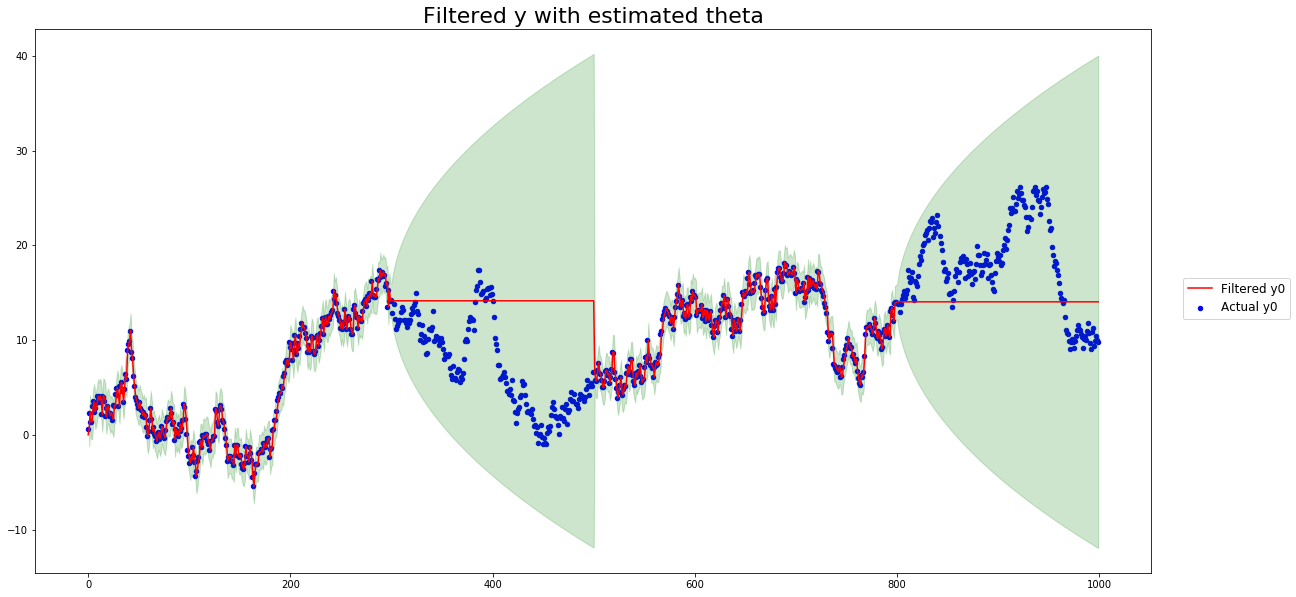

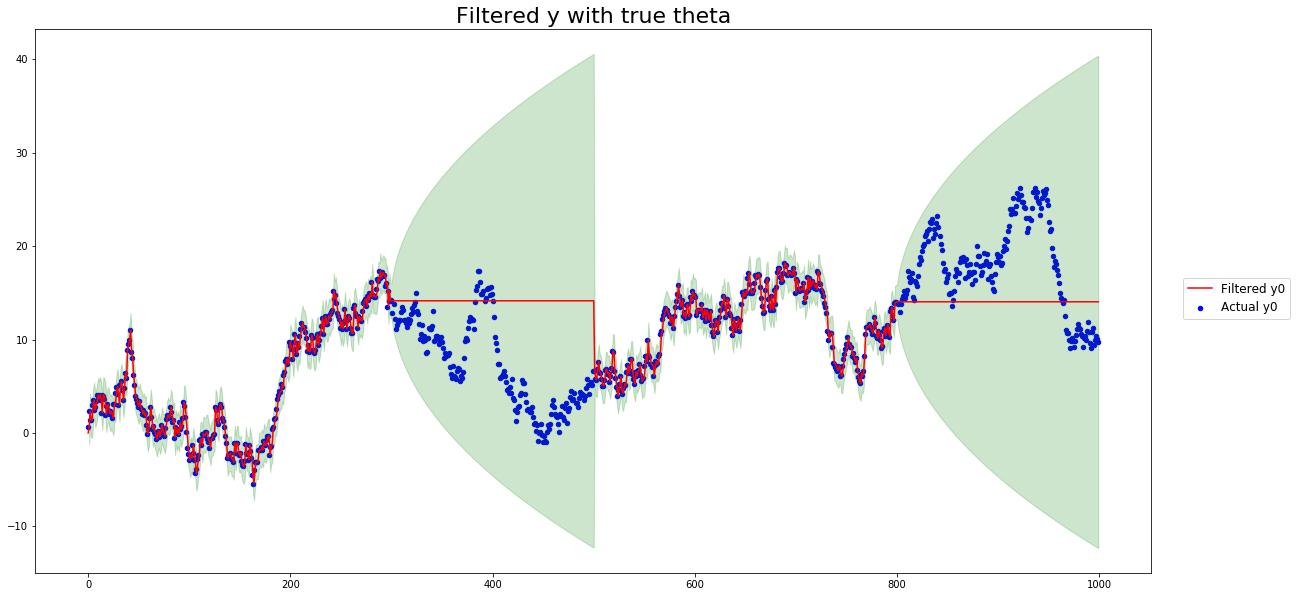

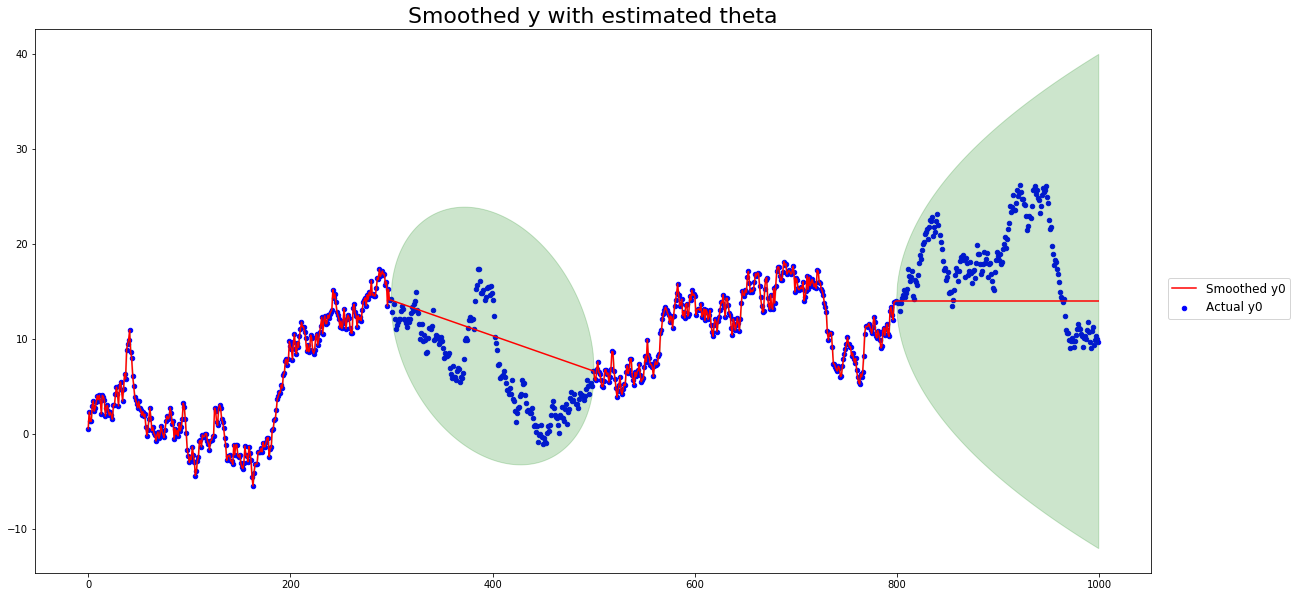

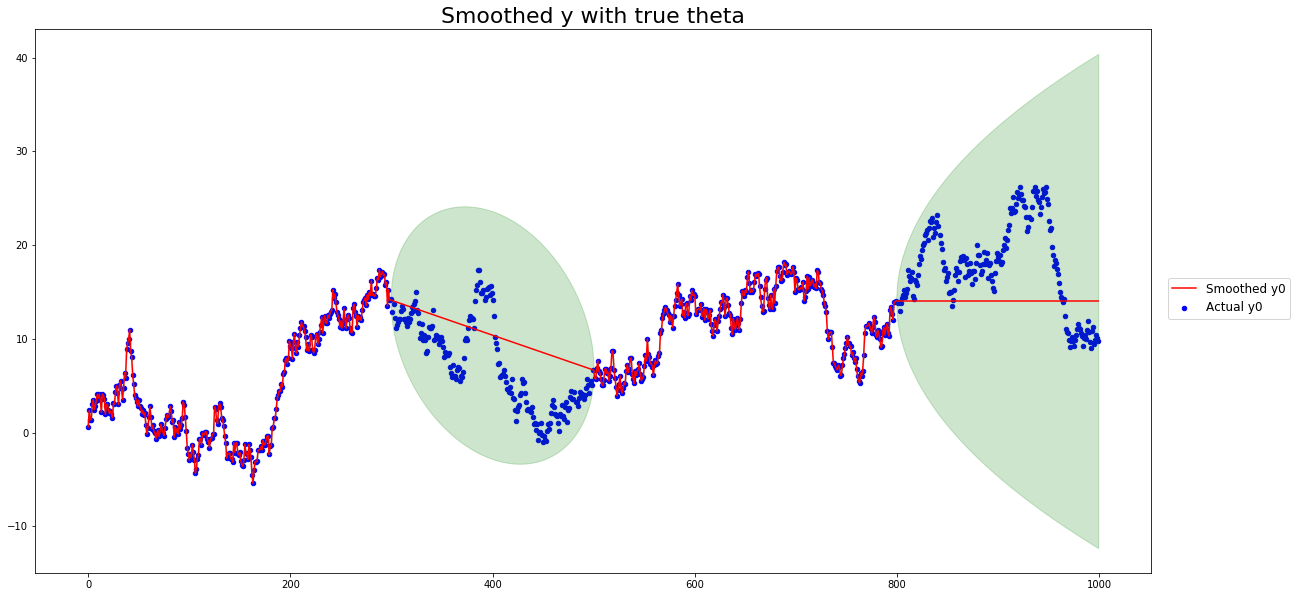

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with estimated theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 4.084823608467634, 'mean_error': 1.91854434130238}
Ture theta for training data: {'RMSE': 4.084754618612036, 'mean_error': 1.9185027722806447}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 0.872485716553662, 'mean_error': 0.009577648418177471}
Ture theta for test data: {'RMSE': 0.872485669475103, 'mean_error': 0.00957650767220013}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 4.726605380750964, 'mean_error': -3.8083142751714245}
Ture theta for forecast data: {'RMSE': 4.726588297285029, 'mean_error': -3.8084553720796386}
